# Машинное обучение "без учителя". Задача кластеризации.
# В практических примерах ниже показано:

* как пользоваться инструментами визуального анализа для предварительной интерпретации кластеров
* как проводить кластерный анализ
* как строить прогноз принадлежности к кластерам новых наблюдений
* как оценивать точность кластеризации
Модели: иерархический и неиерархический кластерный анализ

Данные: load_breast_cancer

In [3]:
import numpy as np
import pandas as pd
# процедура стандартизации
from sklearn.preprocessing import StandardScaler
# алгоритм k-средних
from sklearn.cluster import KMeans
# алгоритм k-ближайших соседей
from sklearn.neighbors import KNeighborsClassifier
# дендрограмма
from scipy.cluster.hierarchy import dendrogram, linkage
# дендрограмма, расчет матрицы расстояний
from scipy.spatial.distance import pdist
# метрики
from sklearn import metrics 
# кластерные силуэты
from matplotlib import cm 
from sklearn.metrics import silhouette_samples
from matplotlib import pyplot as plt
import seaborn
seaborn.set_theme()

In [21]:
from sklearn.datasets import load_breast_cancer
data=load_breast_cancer ()
data

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

 Задача состоит в разделении ирисов на группы в зависимости от показателей(mean symmetry, mean concavity)


In [48]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df = df[['mean symmetry', 'mean concavity']]
df.columns = ["symmetry", "concavity"]
df

,symmetry,concavity
0,0.2419,0.30010
1,0.1812,0.08690
2,0.2069,0.19740
3,0.2597,0.24140
4,0.1809,0.19800
...,...,...
564,0.1726,0.24390
565,0.1752,0.14400
566,0.1590,0.09251
567,0.2397,0.35140


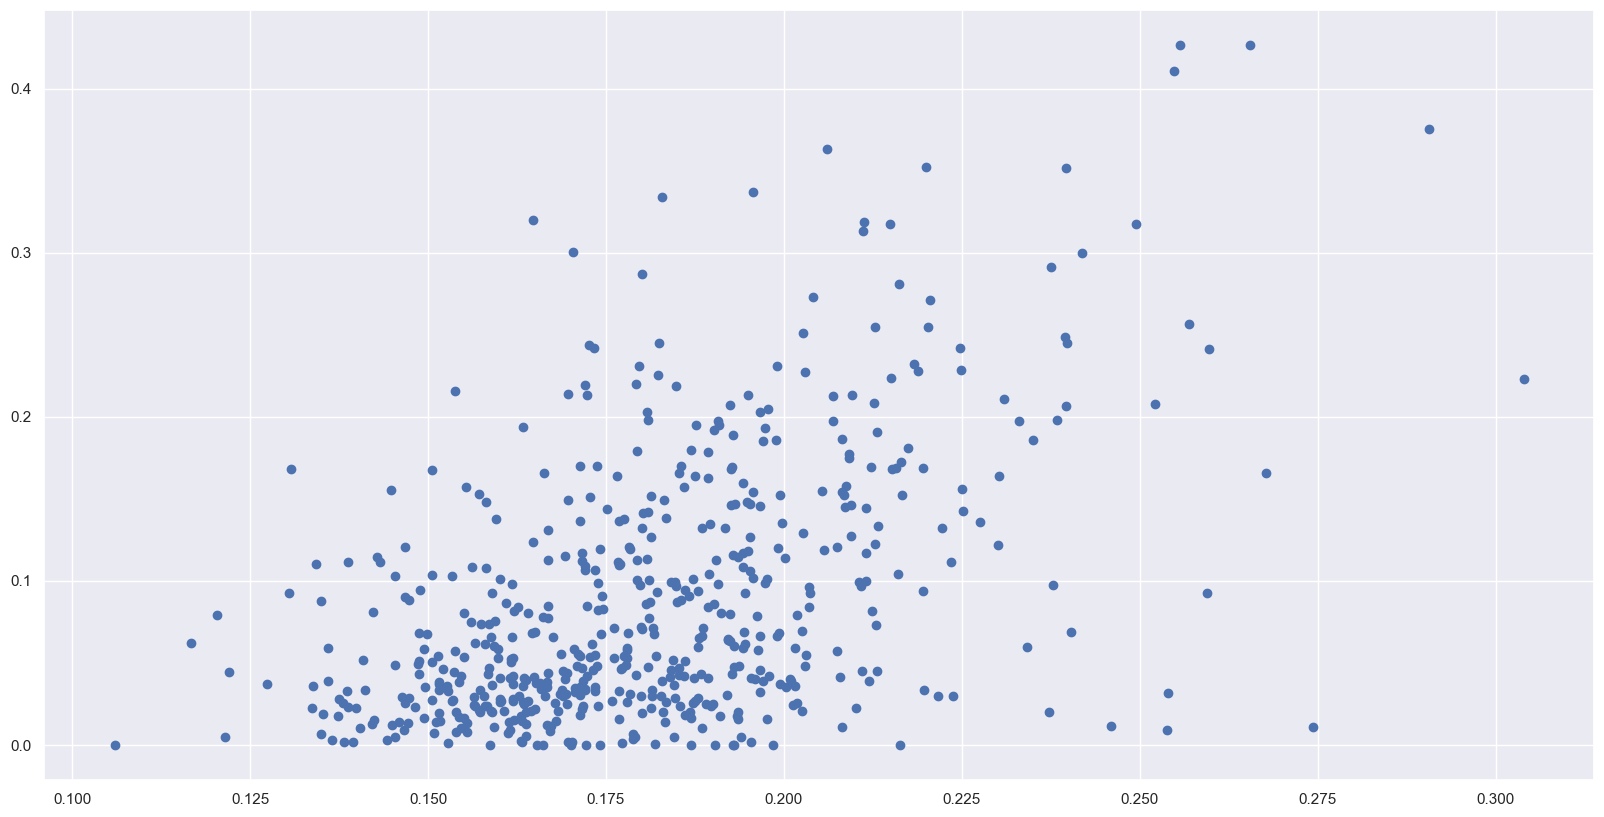

In [49]:
plt.figure(figsize=(20,10))
plt.scatter(df.symmetry, df.concavity)

В нашем примере наблюдения визуально нельзя сгруппировать. Поэтому рассмотрим метод для определения наилучшего количества кластеров.


## Определение оптимального количества кластеров для метода локтя
Одна из основных трудностей в обучении без учителя состоит в том, что мы не знаем точного ответа. В нашем наборе данных нет 
установленных данных о метках классов, поэтому для количественного определения качества кластеризации нам нужно использовать внутренние метрики - такие как внутрикластерная **SSE** (искажение или инерция):
$$SSE = \sum\limits_{i=1}^n\sum\limits_{j=1}^kw_{ij}(x_i - m_i)^2$$
Здесь $w_{ij}$ = 1, если наблюдение относится к кластеру $j$ и 0 в противоположном случае, а $m_i$ - центроид кластера.

Основываясь на внутрикластерной SSE, мы можем применить графический инструмент, так называемый метод локтя, для оценки оптимального числа k кластеров для поставленной задачи. Интуитивно мы можем сказать, что если k увеличивается, то искажение уменьшается. Это вызвано тем, что образцы будут ближе к центроидам, которым они назначены. В основе метода локтя лежит идея, которая состоит в том, чтобы идентифицировать значение k в точке, где искажение начинает увеличиваться быстрее всего, что станет понятнее, если мы построим график искажения для разных значений k.

C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\sklearn\cluster\_kmeans.py:1332: 

Text(0, 0.5, 'Искажение ')

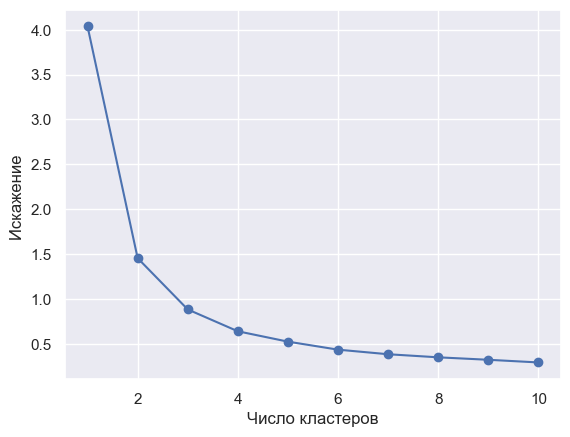

In [51]:
distortions = [] 
for i in range (1, 11): 
    km = KMeans(n_clusters=i, 
                init='random', 
                n_init=10 , 
                max_iter=300, 
                random_state=0) 
    km.fit(df)
    distortions.append(km.inertia_) 
plt.plot(range(1, 11) , distortions , marker='o') 
plt.xlabel('Чиcлo кластеров') 
plt.ylabel ('Искажение ' ) 

Как видно на следующем выше графике, локоть расположен в k = 4, что свидетельствует о том, что k = 4 является хорошим выбором для этого набора данных

C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


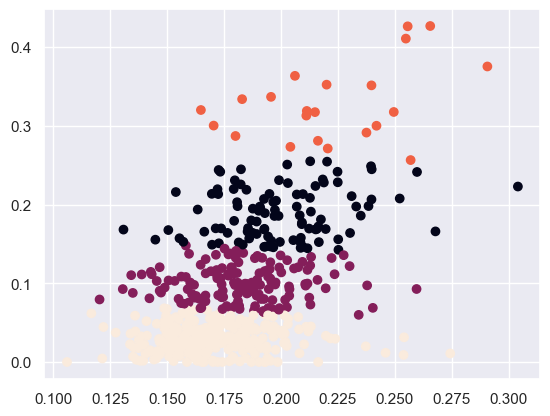

In [54]:
kmeans = KMeans(n_clusters=4,random_state=0).fit(df.values)
plt.scatter(df.symmetry, df.concavity, c=kmeans.labels_)

Тем не менее, визуальный анализ говорит о наличии 3 различных групп. Сделаем и такое построение:

C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


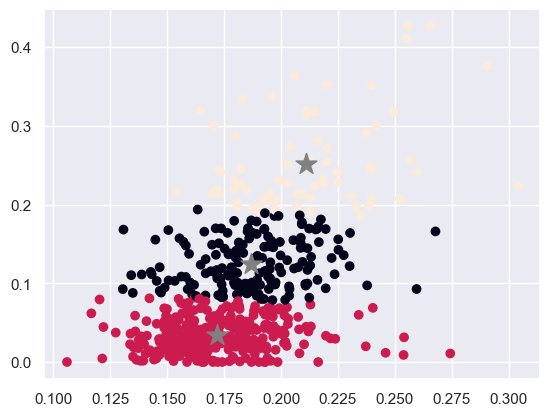

In [56]:
kmeans = KMeans(n_clusters=3,random_state=0).fit(df.values)
plt.scatter(df.symmetry, df.concavity, c=kmeans.labels_)
# нарисуем центроиды
plt.scatter(kmeans.cluster_centers_ [:, 0], kmeans.cluster_centers_ [:, 1], 
           s=250, marker= '*', c = 'grey', label = 'центроиды')

Теперь видим, что каждая группа точек покрашена в цвет соответствующего кластера, а центроиды расположены внутри множества точек. Тем не менее, попробуем оценить качество кластеризации в обоих вариантах.

### Количественная оценка качества кластеризации
Задача оценки качества кластеризации является более сложной по сравнению с оценкой качества классификации. Во-первых, такие оценки не должны зависеть от самих значений меток, а только от самого разбиения выборки. Во-вторых, не всегда известны истинные метки объектов, поэтому также нужны оценки, позволяющие оценить качество кластеризации, используя только неразмеченную выборку.

Выделяют внешние и внутренние метрики качества. Внешние используют информацию об истинном разбиении на кластеры, в то время как внутренние метрики не используют никакой внешней информации и оценивают качество кластеризации, основываясь только на наборе данных. Оптимальное число кластеров обычно определяют с использованием внутренних метрик.


C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Средний коэффициент силуэта --  0.5091726018519279


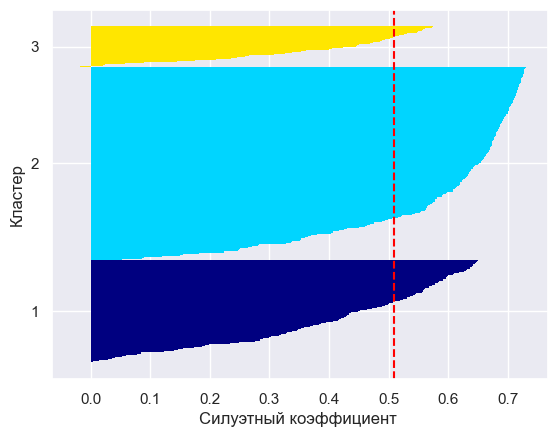

In [58]:
kmeans = KMeans(n_clusters=3,random_state=0).fit(df.values)
# метки кластеров для каждого наблюдения
y_km = kmeans.fit_predict(df) 

cluster_labels = np.unique(y_km) 
n_clusters = cluster_labels.shape[0] 
silhouette_vals = silhouette_samples(df, y_km, metric='euclidean')

# изобразим график силуэтов
y_ax_lower , y_ax_upper = 0, 0 
yticks = [] 
for i, c in enumerate(cluster_labels): 
    c_silhouette_vals = silhouette_vals[y_km == c] 
    c_silhouette_vals.sort() 
    y_ax_upper += len(c_silhouette_vals) 
    color = cm.jet(float(i) / n_clusters) 
    plt.barh(range(y_ax_lower, y_ax_upper), 
             c_silhouette_vals , 
             height=1.0, 
             edgecolor='none', 
             color=color) 
    yticks.append((y_ax_lower + y_ax_upper) / 2) 
    y_ax_lower += len(c_silhouette_vals) 
silhouette_avg = np.mean(silhouette_vals) 
    
plt.axvline(silhouette_avg, color= "red", linestyle="--" ) 
print ("Средний коэффициент силуэта -- ", silhouette_avg)
plt.yticks(yticks, cluster_labels + 1) 
plt.ylabel ('Кластер') 
plt.xlabel('Силуэтный коэффициент ' ) 
plt.show() 

Средний коэффициент силуэта весьма близок к 0.5 , что говорит о относительным качестве кластеризации. Если силуэты зрительно значительно отличаются друг от друга по длине, то это является признаком субоптимальной кластеризации. Как правило, в этом случае центроиды кластеров стоят отдельно от множества точек кластера. Посчитаем средний силуэтный коэффициент для кластеризации k=4.

In [59]:
kmeans = KMeans(n_clusters=4,random_state=0).fit(df.values)
# метки кластеров для каждого наблюдения
y_km = kmeans.fit_predict(df) 

silhouette_vals = silhouette_samples(df, y_km, metric='euclidean')
silhouette_avg = np.mean(silhouette_vals) 

print ("Средний коэффициент силуэта -- ", silhouette_avg)

C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Средний коэффициент силуэта --  0.46110505790261136


Его значение немного ниже, чем в предыдущем случае. Формально k=3 - более оптимальное разбиение.

### Сравнение результатов на обучающей и тестовой выборке
Посмотрим, как прогнозировать новых наблюдений принадлежность к кластерам, построенным по обучающим данным. Сравним значения средних силуэтных коэффициентов.

В обучающей выборке - 80% исходных наблюдений.

In [60]:
DF = pd.DataFrame(data.data, columns=data.feature_names)
DF = DF[['mean symmetry', 'mean concavity', 'mean compactness']]
DF.columns = ["symmetry", "concavity", "compactness"]
DF

,symmetry,concavity,compactness
0,0.2419,0.30010,0.27760
1,0.1812,0.08690,0.07864
2,0.2069,0.19740,0.15990
3,0.2597,0.24140,0.28390
4,0.1809,0.19800,0.13280
...,...,...,...
564,0.1726,0.24390,0.11590
565,0.1752,0.14400,0.10340
566,0.1590,0.09251,0.10230
567,0.2397,0.35140,0.27700


In [61]:
DF_train = DF.sample(frac=0.8)

# данные для прогнозов
DF_predict = DF.drop(DF_train.index)

C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\sklearn\cluster\_kmeans.py:1332: 

Text(0, 0.5, 'Искажение ')

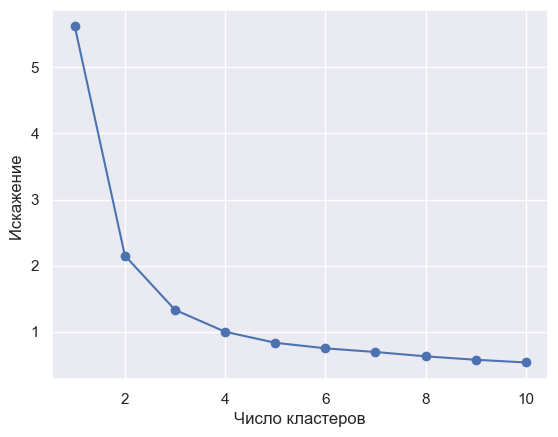

In [62]:
distortions = [] 
for i in range (1, 11): 
    km = KMeans(n_clusters=i, 
                init='random', 
                n_init=10 , 
                max_iter=300, 
                random_state=0) 
    km.fit(DF)
    distortions.append(km.inertia_) 
plt.plot(range(1, 11) , distortions , marker='o') 
plt.xlabel('Чиcлo кластеров') 
plt.ylabel ('Искажение ' ) 

Как видно на следующем выше графике, заметных изменений не обнаружилось.

Обучаем алгоритм и считаем средний силуэтный коэффициент.

In [63]:
kmeans = KMeans(n_clusters=3,random_state=0).fit(DF_train.values)
y_km_train = kmeans.fit_predict(DF_train) 
silhouette_vals = silhouette_samples(DF_train, y_km_train, metric='euclidean')
silhouette_avg = np.mean(silhouette_vals) 
print ("Средний коэффициент силуэта -- ", silhouette_avg)

C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Средний коэффициент силуэта --  0.47597534225166577


In [64]:
y_km_predict = kmeans.fit_predict(DF_predict) 
silhouette_vals = silhouette_samples(DF_predict, y_km_predict, metric='euclidean')
silhouette_avg = np.mean(silhouette_vals) 
print ("Средний коэффициент силуэта -- ", silhouette_avg)

C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Средний коэффициент силуэта --  0.4685917416506772


Применяем модель к новым данным. Значение среднего силуэтного коэффициента незначительно ухудшилось.

Статистический анализ получившихся кластеров

In [65]:
# снова работаем со всей выборкой
# добавляем метки кластеров в качестве нового столбца к фрейму
kmeans = KMeans(n_clusters=3,random_state=0).fit(DF.values)
DF["KM"] = kmeans.fit_predict(DF) 

C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


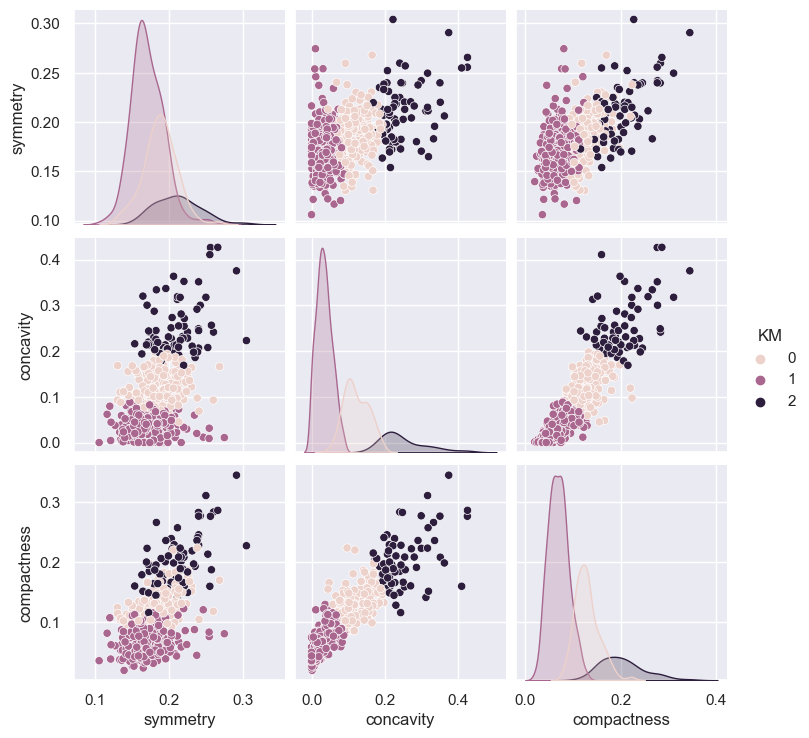

In [66]:
seaborn.pairplot(DF, hue='KM')
plt.show()

In [67]:
from sklearn.metrics import accuracy_score
kmeans = KMeans(n_clusters=3, random_state=0)

# Обучение модели на данных
kmeans.fit(df)
preds = kmeans.predict(df)

# Получение фактического разбиения на группы из колонки "target" в исходном датасете
actual = data.target

# Расчет метрики Acc
acc = accuracy_score(actual, preds)

print(f"Accuracy: {acc}")

C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Accuracy: 0.7539543057996485


Из оценки кластеризации следует, что алгоритм(при разбиении на 3 кластера) достиг высокой точности в своей работе, указывая правильную категоризацию большинства объектов данных.

In [68]:
kmeans = KMeans(n_clusters=2, random_state=0)

# Обучение модели на данных
kmeans.fit(DF)
preds = kmeans.predict(DF)

# Получение фактического разбиения на группы из колонки "target" в исходном датасете
actual = data.target

# Расчет метрики Acc
acc = accuracy_score(actual, preds)

print(f"Accuracy: {acc}")

C:\Users\user\anaconda3\envs\natashaevv\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Accuracy: 0.7346221441124781


Из оценки кластеризации следует, что алгоритм(при разбиении на 2 кластера) достиг высокой точности в своей работе, указывая правильную категоризацию большинства объектов данных.